<img src="http://oproject.org/tiki-download_file.php?fileId=8&display&x=450&y=128">
<img src="http://files.oproject.org/tmvalogo.png" height="50%" width="50%">

# TMVA Classification Example

## Declare Factory

Create the Factory class. Later you can choose the methods
whose performance you'd like to investigate. 

The factory is the major TMVA object you have to interact with. Here is the list of parameters you need to pass

 - The first argument is the base of the name of all the output
weightfiles in the directory weight/ that will be created with the 
method parameters 

 - The second argument is the output file for the training results
  
 - The third argument is a string option defining some general configuration for the TMVA session. For example all TMVA output can be suppressed by removing the "!" (not) in front of the "Silent" argument in the option string

In [1]:
TMVA::Tools::Instance();


auto outputFile = TFile::Open("TMVA_ClassificationOutput.root", "RECREATE");

TMVA::Factory factory("TMVAClassification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" ); 

### Setup input Dataset

Define input data file and signal and background trees

In [2]:
TString inputFileName = "http://root.cern.ch/files/tmva_class_example.root";
//TString inputFileName = "tmva_class_example.root";

auto inputFile = TFile::Open( inputFileName );

// --- Register the training and test trees

TTree *signalTree     = (TTree*)inputFile->Get("TreeS");
TTree *backgroundTree = (TTree*)inputFile->Get("TreeB");


## DataLoader

The next step is to declare the DataLoader class which provides the interface from TMVA to the input data 


In [3]:
TMVA::DataLoader * loader = new TMVA::DataLoader("dataset");

In [4]:
// global event weights per tree (see below for setting event-wise weights)
Double_t signalWeight     = 1.0;
Double_t backgroundWeight = 1.0;
   
// You can add an arbitrary number of signal or background trees
loader->AddSignalTree    ( signalTree,     signalWeight     );
loader->AddBackgroundTree( backgroundTree, backgroundWeight );


DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree TreeS of type Signal with 6000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree TreeB of type Background with 6000 events


### Define input variables

Through the DataLoader we define the input variables that will be used for the MVA training.
Note that we can also use variable expressions, which can be parsed by *TTree::Draw( "expression" )*

In [5]:
loader->AddVariable( "myvar1 := var1+var2", 'F' );
loader->AddVariable( "myvar2 := var1-var2", "Expression 2", "", 'F' );
loader->AddVariable( "var3",                "Variable 3", "units", 'F' );
loader->AddVariable( "var4",                "Variable 4", "units", 'F' );

// You can add so-called "Spectator variables", which are not used in the MVA training,
// but will appear in the final "TestTree" produced by TMVA. This TestTree will contain the
// input variables, the response values of all trained MVAs, and the spectator variables
loader->AddSpectator( "spec1 := var1*2",  "Spectator 1", "units", 'F' );
loader->AddSpectator( "spec2 := var1*3",  "Spectator 2", "units", 'F' );


//  We can define also the event weights

// Set individual event weights (the variables must exist in the original TTree)
//    for signal    : factory->SetSignalWeightExpression    ("weight1*weight2");
//    for background: factory->SetBackgroundWeightExpression("weight1*weight2");
loader->SetBackgroundWeightExpression( "weight" );


### Prepare data splitting in training and test sample 

In [6]:
// Apply additional cuts on the signal and background samples (can be different)
TCut mycuts = ""; // for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
TCut mycutb = ""; // for example: TCut mycutb = "abs(var1)<0.5";

// Tell the factory how to use the training and testing events
//
// If no numbers of events are given, half of the events in the tree are used 
// for training, and the other half for testing:
//    loader->PrepareTrainingAndTestTree( mycut, "SplitMode=random:!V" );
// To also specify the number of testing events, use:
//    loader->PrepareTrainingAndTestTree( mycut,
//                                         "NSigTrain=3000:NBkgTrain=3000:NSigTest=3000:NBkgTest=3000:SplitMode=Random:!V" );
loader->PrepareTrainingAndTestTree( mycuts, mycutb,
                                    "nTrain_Signal=0:nTrain_Background=0:SplitMode=Random:NormMode=NumEvents:!V" );


# Booking Methods


We Book here the different MVA method we want to use. 
We specify the method using the appropriate enumeration, defined in *TMVA::Types*.
See the file *TMVA/Types.h* for all possible MVA methods available. 
In addition, we specify via an option string all the method parameters. For all possible options, default parameter values, see the corresponding documentation in the TMVA Users Guide. 

Note that with the booking one can also specify individual variable tranformations to be done before using the method.
For example *VarTransform=Decorrelate* will decorrelate the inputs.  

In [7]:
// Likelihood ("naive Bayes estimator")
factory.BookMethod(loader, TMVA::Types::kLikelihood, "Likelihood",
                           "H:!V:TransformOutput:PDFInterpol=Spline2:NSmoothSig[0]=20:NSmoothBkg[0]=20:NSmoothBkg[1]=10:NSmooth=1:NAvEvtPerBin=50" );

// Use a kernel density estimator to approximate the PDFs
factory.BookMethod(loader, TMVA::Types::kLikelihood, "LikelihoodKDE",
                           "!H:!V:!TransformOutput:PDFInterpol=KDE:KDEtype=Gauss:KDEiter=Adaptive:KDEFineFactor=0.3:KDEborder=None:NAvEvtPerBin=50" ); 


// Fisher discriminant (same as LD)
factory.BookMethod(loader, TMVA::Types::kFisher, "Fisher", "H:!V:Fisher:VarTransform=None:CreateMVAPdfs:PDFInterpolMVAPdf=Spline2:NbinsMVAPdf=50:NsmoothMVAPdf=10" );

//Boosted Decision Trees
factory.BookMethod(loader,TMVA::Types::kBDT, "BDT",
                   "!V:NTrees=200:MinNodeSize=2.5%:MaxDepth=2:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20" );

//Multi-Layer Perceptron (Neural Network)
factory.BookMethod(loader, TMVA::Types::kMLP, "MLP",
                   "!H:!V:NeuronType=tanh:VarTransform=N:NCycles=100:HiddenLayers=N+5:TestRate=5:!UseRegulator" );

Factory                  : Booking method: Likelihood
                         : 
Factory                  : Booking method: LikelihoodKDE
                         : 
Factory                  : Booking method: Fisher
                         : 
Factory                  : Booking method: BDT
                         : 
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 3000
                         : Signal     -- testing events             : 3000
                         : Signal     -- training and testing events: 6000
                         : Background -- training events            : 3000
                         : Background -- testing events             : 3000
          

## Train all methods

Here we train all previously booked methods

In [8]:
factory.TrainAllMethods();

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'myvar1' <---> Output : variable 'myvar1'
                         : Input : variable 'myvar2' <---> Output : variable 'myvar2'
                         : Input : variable 'var3' <---> Output : variable 'var3'
                         : Input : variable 'var4' <---> Output : variable 'var4'
TFHandler_Factory        : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :   myvar1:  -0.019360     1.7427   [    -8.9660     7.6931 ]
                         :   myvar2: -0.0098967     1.1059   [    -4.0854     4.0259 ]
                         :     var3: -0.0084328     1.0724   [    -5.0508     4.359

                         : Creating standalone class: dataset/weights/TMVAClassification_Fisher.class.C
Factory                  : Training finished
                         : 
Factory                  : Train method: BDT for Classification
                         : 
BDT                      : #events: (reweighted) sig: 3000 bkg: 3000
                         : #events: (unweighted) sig: 3000 bkg: 3000
                         : Training 200 Decision Trees ... patience please
                         : Elapsed time for training with 6000 events: 5.34 sec         
BDT                      : [dataset] : Evaluation of BDT on training sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.0716 sec       
                         : Creating xml weight file: dataset/weights/TMVAClassification_BDT.weights.xml
                         : Creating standalone class: dataset/weights/TMVAClassification_BDT.class.C
Factory                  : Training finished


## Test  all methods

Here we test all methods using the test data set

In [9]:
factory.TestAllMethods();  

Factory                  : Test all methods
Factory                  : Test method: Likelihood for Classification performance
                         : 
Likelihood               : [dataset] : Evaluation of Likelihood on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.0123 sec       
Factory                  : Test method: LikelihoodKDE for Classification performance
                         : 
LikelihoodKDE            : [dataset] : Evaluation of LikelihoodKDE on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.00858 sec       
Factory                  : Test method: Fisher for Classification performance
                         : 
Fisher                   : [dataset] : Evaluation of Fisher on testing sample (6000 events)
                         : Elapsed time for evaluation of 6000 events: 0.000746 sec       
                         : Dataset[dataset] : Evaluation of Fisher on 

## Evaluate  all methods

Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc.. using both 
training and tetsing data sets. 
Several histograms are produced which can be examined with the TMVAGui or directly using the output file

In [10]:
factory.EvaluateAllMethods();  

Factory                  : Evaluate all methods
Factory                  : Evaluate classifier: Likelihood
                         : 
Likelihood               : [dataset] : Loop over test events and fill histograms with classifier response...
                         : 
TFHandler_Likelihood     : Variable        Mean        RMS   [        Min        Max ]
                         : -----------------------------------------------------------
                         :   myvar1:    0.20474     1.7127   [    -9.8605     7.9024 ]
                         :   myvar2:  -0.053190     1.1047   [    -3.7067     4.0291 ]
                         :     var3:    0.15738     1.0532   [    -5.3563     4.6430 ]
                         :     var4:    0.42980     1.2189   [    -6.9675     5.0307 ]
                         : -----------------------------------------------------------
Factory                  : Evaluate classifier: LikelihoodKDE
                         : 
LikelihoodKDE            : [d

## Plot ROC Curve

We plot here the produce ROC curve obtained on evaluating the methods on the test data set

In [ ]:
//We enable JavaScript visualisation for the plots
//%jsroot on

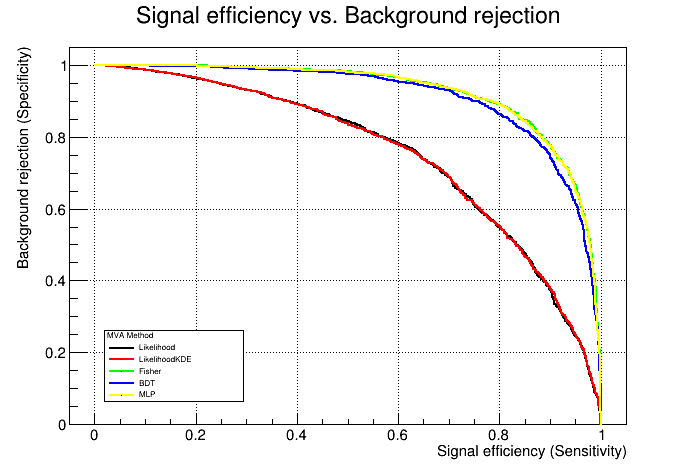

In [11]:
auto c1 = factory.GetROCCurve(loader);
c1->Draw();


####  Close outputfile to save all output information (evaluation result of methods)

In [12]:
outputFile->Close();